# MCMC simulation of Surgical failures

# Imports

In [2]:
%matplotlib inline
from pymc3 import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data

In [38]:
operations = np.array([47, 148, 119, 810, 211, 196, 148, 215, 207, 97, 256, 360]) # Number of operations
deaths = np.array([0, 18, 8, 46, 8, 13, 9, 31, 14, 8, 29, 24]) # Number of deaths

12


## Specify models

The number of deaths ($r_i$) for hospital i = 1, . . . , 12 are modelled as a binary response variable with true failure probability $p_i$

$$ r_i \sim Binomial(p_i, n_i)$$

Consider the two following models

**Model 1:** The failure probabilities are independent for each hospital. i.e. 
$$p_i \sim Beta(1.0, 1.0)$$.

**Model 2:** The failure rates across hospitals are similar in some way. A hierarchical or random effects model for the true failure probabilities $p_i$ can be specified by. 
$$Logit(p_i) = b_i$$
$$b_i \sim Normal(\mu,\sigma^2)$$

## Model 1: Independent hospitals

In [126]:
with Model() as model: # model specifications
    
    # Priors
    pr = Beta('pr', alpha=1, beta=1, shape=(1,12))

    # Likelihood
    rate = Binomial('rate', p=pr, n=operations, observed=deaths)
    
    start = find_MAP() # Find starting value by optimization
    step = NUTS(scaling=start) # Instantiate MCMC sampling algorithm
    trace = sample(10000, step, start=start, progressbar=True, njobs=3) 
    # draw 10000 posterior samples, 3 chains.

/Users/Tranheden/anaconda/lib/python3.5/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"


Optimization terminated successfully.
         Current function value: 58.852295
         Iterations: 30
         Function evaluations: 36
         Gradient evaluations: 36


100%|██████████| 10000/10000 [00:19<00:00, 512.96it/s]


In [128]:
gelman_rubin(trace)['pr'] # Probably converged

array([[ 0.99999143,  0.99996592,  0.9999768 ,  0.9999523 ,  0.99997096,
         0.99999749,  1.00000433,  0.99997809,  0.99996789,  0.99996206,
         0.99995427,  0.99998707]])

## Model 1: Inference

In [129]:
sum = df_summary(trace[1000:], varnames=['pr']) # Burn in.
sum['MLE'] = deaths/operations # The MLE estimate of every hospital
sum

,mean,sd,mc_error,hpd_2.5,hpd_97.5,MLE
pr__0_0,0.020399,0.019900,0.000120,0.000001,0.060219,0.000000
pr__0_1,0.126683,0.026649,0.000132,0.076949,0.180604,0.121622
pr__0_2,0.074285,0.023566,0.000122,0.031747,0.121151,0.067227
pr__0_3,0.057923,0.008229,0.000040,0.041985,0.074196,0.056790
pr__0_4,0.042332,0.013812,0.000063,0.017494,0.069633,0.037915
pr__0_5,0.070753,0.018190,0.000083,0.037365,0.106763,0.066327
pr__0_6,0.066481,0.020315,0.000100,0.029949,0.107344,0.060811
pr__0_7,0.147677,0.024129,0.000117,0.102202,0.196335,0.144186
pr__0_8,0.071759,0.017747,0.000092,0.037734,0.106251,0.067633
pr__0_9,0.091065,0.028691,0.000147,0.039537,0.147747,0.082474


Each density is centred on their MLEs $p_i = \frac{r_i}{n_i}$, and so there are some clear location and scale (which is dependent on $n_i$) differences between the posteriors. Notice that the density for $p_1$ still has considerable density away from 0.

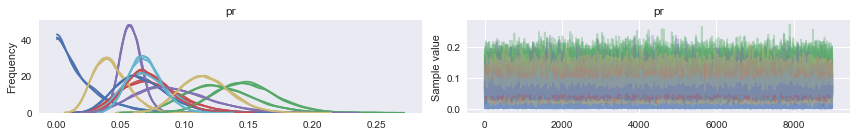

In [130]:
plt.figure(figsize=(1, 1))
traceplot(trace[1000:], varnames = ['pr'])
plt.tight_layout()

# Model 2: Hierarchical model

In [131]:
from pymc3.math import invlogit

with Model() as model: # model specifications
    
    # Inverse logit
    logitInv = lambda x: np.exp(x)/(1.0+np.exp(x))
    
    # Priors
    sigma = InverseGamma('sigma', alpha = 10, beta = 10)
    mu = Normal('mu', mu = 0, sd = 1e3)
    pbar = Deterministic('pbar',invlogit(mu))
    
    b = Normal('b', mu = mu, sd = sigma, shape=(1,12))
    pr = Deterministic('pr',invlogit(b))

    # Likelihood
    rate = Binomial('rate', p=pr, n=operations, observed=deaths)
    
    var = ['sigma', 'pbar', 'pr']
    
    start = find_MAP() # Find starting value by optimization
    step = NUTS(scaling=start) # Instantiate MCMC sampling algorithm
    trace = sample(10000, step, start=start, progressbar=True, njobs=3) 
    # draw 10000 posterior samples, 3 chains.

/Users/Tranheden/anaconda/lib/python3.5/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"


Optimization terminated successfully.
         Current function value: 43.489657
         Iterations: 33
         Function evaluations: 40
         Gradient evaluations: 40


100%|██████████| 10000/10000 [00:28<00:00, 353.22it/s]


In [132]:
gelman_rubin(trace) # Probably converged

{'b': array([[ 0.99995368,  1.00005226,  0.99995229,  0.99997123,  0.99996556,
          0.99998566,  0.99997003,  0.9999561 ,  0.99995429,  0.9999893 ,
          0.99997976,  0.99996285]]),
 'mu': 1.0000110547204284,
 'pbar': 1.0000201154593491,
 'pr': array([[ 0.99999382,  1.0000597 ,  0.999956  ,  0.9999677 ,  0.99998552,
          0.99996929,  0.99997553,  0.99996324,  0.9999577 ,  1.00000215,
          0.99998053,  0.99995982]]),
 'sigma': 1.0001192792436,
 'sigma_log_': 1.0001015054647957}

In [133]:
df_summary(trace[1000:], varnames = var) # Burn in.

,mean,sd,mc_error,hpd_2.5,hpd_97.5
sigma,0.720836,0.164001,0.001296,0.439614,1.050465
pbar,0.070304,0.015153,0.000117,0.041427,0.099690
pr__0_0,0.035847,0.019670,0.000136,0.003970,0.074302
pr__0_1,0.113849,0.024441,0.000133,0.067378,0.162009
pr__0_2,0.068508,0.020604,0.000114,0.031204,0.109189
pr__0_3,0.057354,0.007919,0.000042,0.042522,0.073042
pr__0_4,0.043309,0.012847,0.000071,0.020518,0.069477
pr__0_5,0.066978,0.016442,0.000077,0.037917,0.100888
pr__0_6,0.062887,0.018077,0.000091,0.029550,0.098843
pr__0_7,0.136450,0.022465,0.000093,0.092533,0.179987


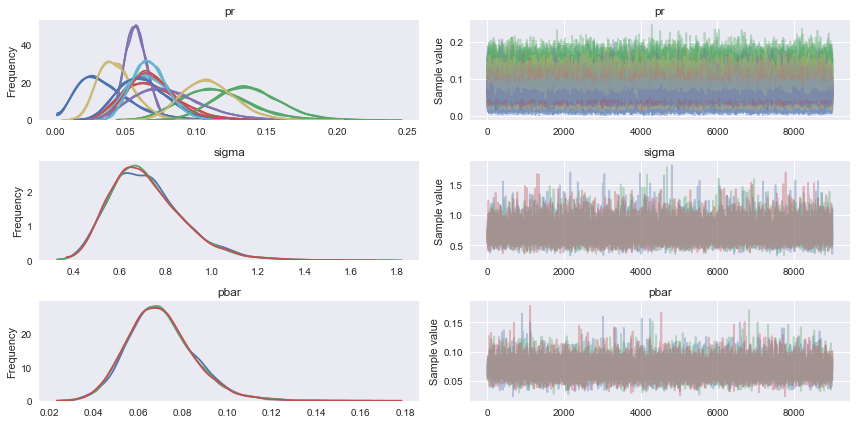

In [134]:
plt.figure(figsize=(3, 3))
traceplot(trace[1000:], varnames = ['pr', 'sigma', 'pbar'])
plt.tight_layout()

Compared to the posterior for Model 1 there have been some changes in that some of the posterior estimates have been pulled closer to the overall posterior mean pbar. The most obvious change is that of $p_1$ which has had its failure rate revised strongly upwards.

This has occured because the individual parameters have “borrowed strength” from the information in the other estimates through the hierarchical prior. The posterior for $\sigma$ shows that there does appear to be some estimated similarity between the $p_i$’s, as the value of $\sigma$ is low. The posterior of pbar shows the mean of the distribution of the $p_i$’s and describes the overall failure rate, in addition to the value to which the individual $p_i$ estimates are being pulled towards in the hierarchical model.